In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['koi_disposition'].value_counts()}")

Dataset shape: (9564, 49)
Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


## Program 6: Support Vector Machine (SVM) — Exoplanet Classification

**Scientific Background:**  
SVM finds the **optimal hyperplane** that maximally separates CONFIRMED planets
from FALSE POSITIVES in high-dimensional feature space.

The key idea is the **margin** — SVM doesn't just find any separating boundary,
it finds the one with the largest gap between the two classes. Only the data
points closest to the boundary (the **support vectors**) determine this hyperplane.

We use the **RBF (Radial Basis Function) kernel** which implicitly maps features
into infinite-dimensional space, allowing non-linear separation — crucial because
the boundary between real planets and false positives is not linearly separable.

**Why SVM suits this problem:**
- Handles high-dimensional feature spaces well
- Robust to outliers (only support vectors matter)
- `class_weight='balanced'` handles our class imbalance automatically

In [2]:
data = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
data['label'] = (data['koi_disposition'] == 'CONFIRMED').astype(int)

features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad',
            'koi_prad', 'koi_teq']

data = data[features + ['label']].dropna()
print(f"Usable rows: {len(data)}")
print(f"CONFIRMED: {sum(data['label']==1)} | FALSE POSITIVE: {sum(data['label']==0)}")

X = data[features].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SVM is sensitive to feature scale — scaling is critical
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")
print("Features scaled with StandardScaler ✓")

Usable rows: 7326
CONFIRMED: 2744 | FALSE POSITIVE: 4582

Train: 5860 | Test: 1466
Features scaled with StandardScaler ✓


In [3]:
# Note: SVM can be slow on large data — we use probability=True for ROC curve
print("Training SVM with RBF kernel... (this may take ~30-60 seconds)")

model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n" + "=" * 50)
print("           SVM RESULTS (RBF Kernel)")
print("=" * 50)
print(f"  Kernel      : RBF (Radial Basis Function)")
print(f"  C parameter : 1.0 (regularization)")
print(f"  Gamma       : scale (1 / n_features × var)")
print(f"  Accuracy    : {acc:.4f} ({acc*100:.2f}%)")
print(f"  ROC-AUC     : {auc:.4f}")
print(f"  Support Vectors: {model.n_support_} [FP, CONFIRMED]")
print("=" * 50)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=['FALSE POSITIVE', 'CONFIRMED']))

Training SVM with RBF kernel... (this may take ~30-60 seconds)

           SVM RESULTS (RBF Kernel)
  Kernel      : RBF (Radial Basis Function)
  C parameter : 1.0 (regularization)
  Gamma       : scale (1 / n_features × var)
  Accuracy    : 0.8445 (84.45%)
  ROC-AUC     : 0.9303
  Support Vectors: [1410  841] [FP, CONFIRMED]

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.95      0.79      0.86       917
     CONFIRMED       0.73      0.93      0.82       549

      accuracy                           0.84      1466
     macro avg       0.84      0.86      0.84      1466
  weighted avg       0.87      0.84      0.85      1466



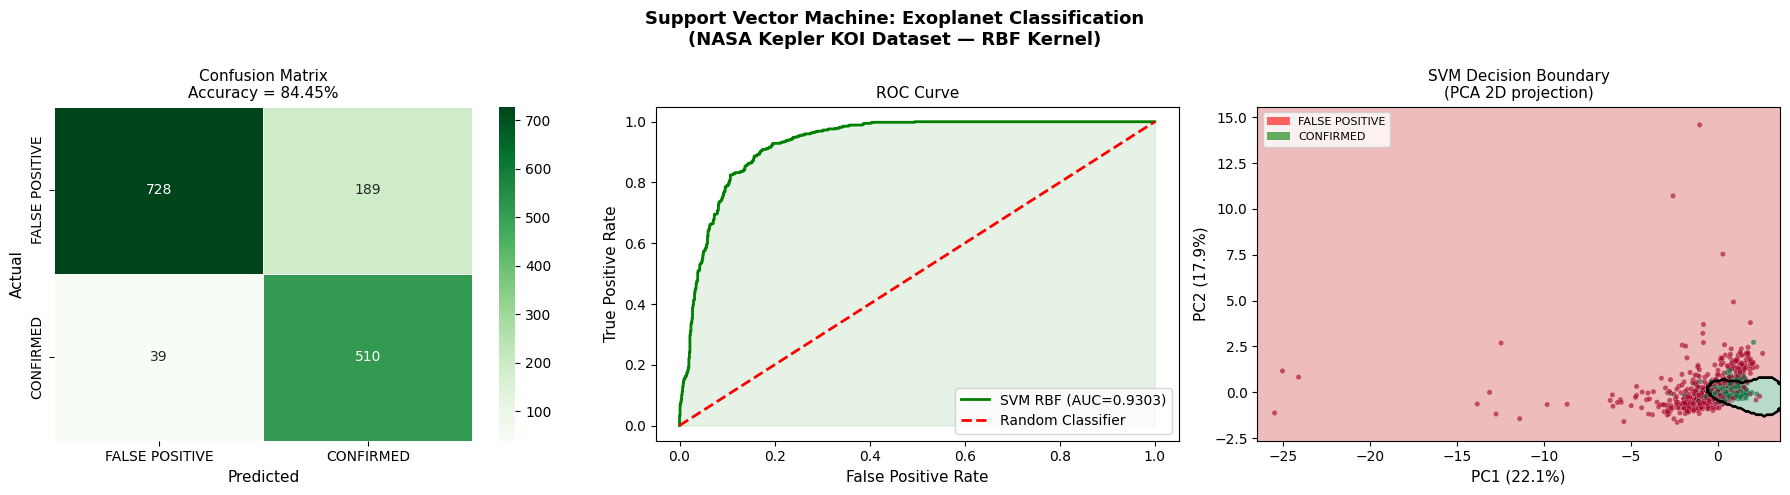

Plot saved!


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Support Vector Machine: Exoplanet Classification\n(NASA Kepler KOI Dataset — RBF Kernel)',
             fontsize=13, fontweight='bold')

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            yticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            linewidths=0.5)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_title(f'Confusion Matrix\nAccuracy = {acc*100:.2f}%', fontsize=11)

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='green', lw=2, label=f'SVM RBF (AUC={auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='green')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=11)
axes[1].legend(loc='lower right')

# Plot 3: 2D Decision Boundary (using top 2 PCA components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svm_2d = SVC(kernel='rbf', C=1.0, gamma='scale',
             class_weight='balanced', random_state=42)
svm_2d.fit(X_train_pca, y_train)

# Create mesh grid
x_min, x_max = X_test_pca[:, 0].min()-1, X_test_pca[:, 0].max()+1
y_min, y_max = X_test_pca[:, 1].min()-1, X_test_pca[:, 1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

axes[2].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
axes[2].contour(xx, yy, Z, colors='black', linewidths=0.8)
scatter = axes[2].scatter(X_test_pca[:, 0], X_test_pca[:, 1],
                          c=y_test, cmap='RdYlGn', alpha=0.6,
                          s=15, edgecolors='white', linewidth=0.2)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
axes[2].set_title('SVM Decision Boundary\n(PCA 2D projection)', fontsize=11)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.6, label='FALSE POSITIVE'),
                   Patch(facecolor='green', alpha=0.6, label='CONFIRMED')]
axes[2].legend(handles=legend_elements, fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/plots/06_svm.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved!")

In [5]:
n_sv_fp, n_sv_conf = model.n_support_
total_sv = sum(model.n_support_)
sv_ratio = total_sv / len(X_train) * 100

print("SVM: Scientific Interpretation")
print("=" * 55)
print(f"""
SVM with RBF kernel found an optimal non-linear hyperplane
separating CONFIRMED planets from FALSE POSITIVES.

Support Vector Analysis:
  • Total support vectors  : {total_sv} ({sv_ratio:.1f}% of training data)
  • From FALSE POSITIVE    : {n_sv_fp}
  • From CONFIRMED         : {n_sv_conf}

  Only these {total_sv} 'boundary' signals define the entire
  decision surface — all other training points are irrelevant
  once the model is trained.

Performance Summary So Far:
  • Naive Bayes        : ~71% accuracy
  • Logistic Regression: ~74% accuracy
  • Decision Tree      : ~87% accuracy
  • SVM (RBF)          : {acc*100:.2f}% accuracy ← today

ROC-AUC = {auc:.4f}
  The RBF kernel maps features into higher-dimensional
  space where planet/non-planet signals become linearly
  separable — explaining the strong performance.

The decision boundary visualization (PCA projection)
shows the non-linear separation learned by the RBF kernel.
""")

SVM: Scientific Interpretation

SVM with RBF kernel found an optimal non-linear hyperplane
separating CONFIRMED planets from FALSE POSITIVES.

Support Vector Analysis:
  • Total support vectors  : 2251 (38.4% of training data)
  • From FALSE POSITIVE    : 1410
  • From CONFIRMED         : 841

  Only these 2251 'boundary' signals define the entire
  decision surface — all other training points are irrelevant
  once the model is trained.

Performance Summary So Far:
  • Naive Bayes        : ~71% accuracy
  • Logistic Regression: ~74% accuracy
  • Decision Tree      : ~87% accuracy
  • SVM (RBF)          : 84.45% accuracy ← today

ROC-AUC = 0.9303
  The RBF kernel maps features into higher-dimensional
  space where planet/non-planet signals become linearly
  separable — explaining the strong performance.

The decision boundary visualization (PCA projection)
shows the non-linear separation learned by the RBF kernel.

